### Imports

In [1]:
import numpy as np
import pandas as pd
from numpy import pi, cos, sin, array, exp, sqrt, log10

In [2]:
from scipy import signal

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=3, suppress=True)

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

### Modulation and Demodulation

In [5]:
N = 8 # Seq length
symbols = array([1-1j, -1+1j, 1+1j, -1+1j, 1-1j, 1+1j, -1-1j, -1+1j])/sqrt(2)

# Modulation
idft_out = np.zeros_like(symbols)
for n in np.arange(N):
    m = np.arange(N)
    tones = exp(2j*pi*n*m/N)
    idft_out[n] = np.dot(symbols, tones)
    
guard = idft_out[-2:]
ofdm_symbol = np.concatenate((guard, idft_out))

# Demodulation
dft_out = np.zeros_like(symbols)
ofdm_symbol_no_guard = ofdm_symbol[len(guard):]
for m in np.arange(N):
    n = np.arange(N)
    tone = exp(-2j*pi*n*m/N)
    dft_out[m] = np.dot(ofdm_symbol_no_guard, tone)/N
    
dft_out * sqrt(2)

array([ 1.-1.j, -1.+1.j,  1.+1.j, -1.+1.j,  1.-1.j,  1.+1.j, -1.-1.j,
       -1.+1.j])

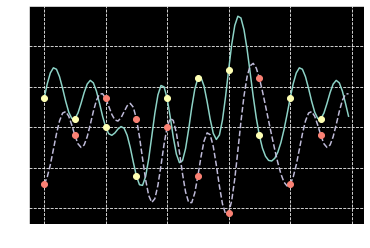

In [6]:
nn = np.arange(-2, N, 0.1)
waveform = np.zeros_like(nn, complex)
for m in np.arange(N):
    tone = exp(2j*pi*nn*m/N)
    waveform += symbols[m]*tone

# Somehow the waveform does not match the one shown in book
plt.plot(nn, waveform.real, np.arange(-2,N), ofdm_symbol.real, 'o')
plt.plot(nn, waveform.imag, '--', np.arange(-2,N), ofdm_symbol.imag, 'o')
plt.grid(ls='dashed')

### Header Information

#### Short Training Sequence

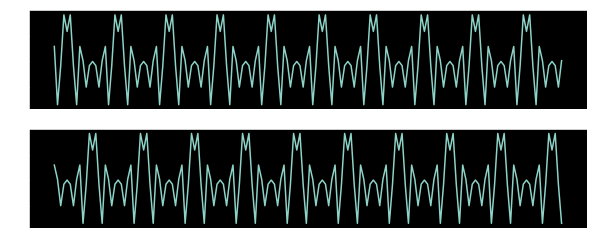

In [7]:
def short_training_sequence():
    positive = np.zeros(32, complex)
    positive[[4, 8, 12, 16, 20, 24]] = [-1-1j, -1-1j, 1+1j, 1+1j, 1+1j, 1+1j]

    negative = np.zeros(32, complex)
    negative[[8, 12, 16, 20, 24, 28]] = [1+1j, -1-1j, 1+1j, -1-1j, -1-1j, 1+1j]

    total = np.concatenate((negative, positive))*sqrt(13/6)
    tone_indices = np.arange(-32, 32)
    N = len(tone_indices)

    n = np.arange(20*8) # 8 usecs @ 20 MSPS
    training_seq = np.zeros_like(n, complex)
    for idx, m in enumerate(tone_indices):
        training_seq += total[idx]*exp(2j*pi*n*m/N)
        
    return training_seq

# Call function
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
short_seq = short_training_sequence()
ax1.plot(short_seq.real)
ax2.plot(short_seq.imag);

#### Long Training Sequence

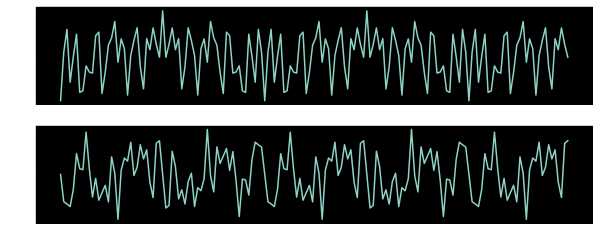

In [8]:
def long_training_sequence():
    positive = array([0, 1, -1, -1, 1, 1, -1, 1,
                      -1, 1, -1, -1, -1, -1, -1, 1,
                      1, -1, -1, 1, -1, 1, -1, 1,
                      1, 1, 1, 0, 0, 0, 0, 0])
    negative = array([0, 0, 0, 0, 0, 0, 1, 1,
                      -1, -1, 1, 1, -1, 1, -1, 1,
                      1, 1, 1, 1, 1, -1, -1, 1, 
                      1, -1, 1, -1, 1, 1, 1, 1])
    total = np.concatenate([negative, positive])
    tone_indices = np.arange(-32, 32)
    N = len(tone_indices)

    n = np.arange(20*3.2) # 3.2 usecs @ 20 MSPS
    training_symbol = np.zeros_like(n, complex)
    for idx, m in enumerate(tone_indices):
        training_symbol += total[idx] * exp(2j*pi*n*m/N)
    
    guard = training_symbol[-32:]
    training_seq = np.concatenate((guard, training_symbol, training_symbol))
    return training_seq

# Call function
long_seq = long_training_sequence()
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
ax1.plot(long_seq.real)
ax2.plot(long_seq.imag);

#### Mapper

In [9]:
class Mapper:
    
    def __init__(self):
        self.BPSK_LUT = array([-1 -1j, 1 + 1j])/np.sqrt(2)
        self.QPSK_LUT = array([-1-1j, -1+1j, 1-1j, 1+1j])/np.sqrt(2)
        self.PSK8_LUT = array([exp(3j*pi/4), -1, 1j, exp(1j*pi/4), 
                               -1j, exp(-3j*pi/4), exp(-1j*pi/4), 1])
        # The scaling factor for 16QAM is sqrt(10), 
        # since avg_power = [4*2 + 8*10 + 4*18]/16 = 10
        # Also the LUT for 16QAM in the book matlab code has an error
        self.QAM16_LUT = array([-3-3j, -3-1j, -3+3j, -3+1j,
                                -1-3j, -1-1j, -1+3j, -1+1j,
                                 3-3j, 3-1j, 3+3j, 3+1j,
                                 1-3j, 1-1j, 1+3j, 1+1j])/np.sqrt(10)
        
    def convert_bit_array_to_int(self, array_of_bits):
        '''
        >>> convert_bit_array_to_int(  np.array([0, 1, 1, 0]) )
        6
        '''
        bit_str = np.array2string(array_of_bits, separator='')[1:-1] #Sliced to remove brackets
        return int(bit_str, 2)
    
    
    def convert_to_symbols(self, bitstream, bits_in_symbol, LUT):
        num_symbols = len(bitstream)//bits_in_symbol
        truncated_bitstream = bitstream[:num_symbols*bits_in_symbol]
        
        if len(truncated_bitstream) != len(bitstream):
            print(f'Truncating {len(bitstream) - len(truncated_bitstream)} bits at the end.')
        
        symbol_bits = np.split(truncated_bitstream, num_symbols) # list of sub-arrays
        symbols = array( [LUT[self.convert_bit_array_to_int(bits)]
                          for bits in symbol_bits] )
        return symbols
        
        
    def bpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=1, LUT=self.BPSK_LUT)
    
    def qpsk(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=2, LUT=self.QPSK_LUT)
    
    def psk8(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=3, LUT=self.PSK8_LUT)
    
    def qam16(self, bitstream):
        return self.convert_to_symbols(bitstream, bits_in_symbol=4, LUT=self.QAM16_LUT)
    
    def qam64(self, bitstream):
        '''
        Uses a different implementation for demonstration purposes
        '''
        QAM64_LUT = array([-7, -5, -3, -1, 1, 3, 5, 7])/sqrt(42)
        num_bits = 6
        
        start_idx = 0
        symbols = []
        while start_idx+num_bits <= len(bitstream):
            selected_bits = bitstream[start_idx: start_idx+num_bits]
            start_idx += num_bits
            
            i_bits = self.convert_bit_array_to_int( selected_bits[:3] )
            q_bits = self.convert_bit_array_to_int( selected_bits[3:] )
            symbol = QAM64_LUT[i_bits] + 1j*QAM64_LUT[q_bits]
            symbols.append(symbol)
            
        return array(symbols)
    
    def modulate(self, bitstream, scheme):
        func = getattr(self, scheme)
        return func(bitstream)
    
# Create a modulator
mapper = Mapper()

#### Payload

In [10]:
def port_to_tone(port):
    '''
    >>> port_to_tone(30)
    30
    >>> port_to_tone(32)
    -32
    '''
    tones = 64
    if port < tones//2:
        return port
    else:
        return port - tones
    
    
def tone_to_port(tone_idx):
    tones = 64
    if tone_idx < 0:
        return tone_idx + tones
    else:
        return tone_idx

In [11]:
def ifft_gi(symbol_stream):
    mod_symbols_per_ofdm_symbol = 48
    samples_per_ofdm_symbol = 80
    ifft_tones = 64
    
    ofdm_symbols = len(symbol_stream) // mod_symbols_per_ofdm_symbol
    payload = np.zeros(ofdm_symbols * samples_per_ofdm_symbol, complex)
    
    pos_idx = [i for i in range(27) if i not in {0, 7, 21}]
    neg_idx = [tone_to_port(i) for i in range(-26,0) if i not in {-21, -7}]
    ifft_idx = pos_idx + neg_idx
    pilot_tones = [tone_to_port(i) for i in (7, 21, -21, -7)]
    
    for idx in range(ofdm_symbols):
        start, stop = idx*mod_symbols_per_ofdm_symbol, (idx+1)*mod_symbols_per_ofdm_symbol
        current_input = symbol_stream[start:stop]
        
        ifft_input = np.zeros(ifft_tones, complex)
        ifft_input[ifft_idx] = current_input
        ifft_input[pilot_tones] = 1
        
        ifft_output = np.fft.ifft(ifft_input)
        guard = ifft_output[-16:]
        p_start, p_stop = idx*samples_per_ofdm_symbol , (idx+1)*samples_per_ofdm_symbol
        payload[p_start: p_start+16] = guard
        payload[p_start+16: p_stop] = ifft_output
    
    return payload*64

In [12]:
random_bits = np.random.choice([0, 1], 48*2)
qpsk = mapper.qpsk(random_bits)
payload = ifft_gi(qpsk)

#### Upsampling

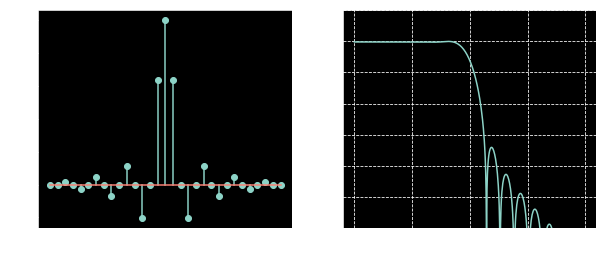

In [13]:
def half_band_filter(plots=False):
    N = 31 # taps
    n = np.arange(N)
    arg = n/2 - (N-1)/4
    hann = np.hanning(N+2)

    # Half band filter response
    h = np.sinc(arg) * (hann[1:-1]**0.5)

    # Freq response
    w, H = signal.freqz(h, 1)
    mag_response = 20*np.log10( abs(H) )
    w_norm = 20e6*w/pi

    # Plots
    if plots:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        ax1.stem(h)

        ax2.plot(w_norm, mag_response - max(mag_response))
        ax2.set_ylim(-60, 10)
        ax2.grid(ls='dashed')
        
    return h

half_band_filter(plots=True);

### Complete OFDM Transmitter

In [14]:
def ofdm_tx_802_11(ofdm_symbols, modulation):
    
    # Get training sequences
    short_train = short_training_sequence()
    long_train = long_training_sequence()
    
    # Generate random bits for mapping
    mod_to_bits = {'bpsk': 1, 'qpsk': 2, 'psk8': 3, 'qam16': 4, 'qam64': 6}
    mod_sym_per_ofdm = 48
    bits_per_mod_sym = mod_to_bits[modulation]
    total_bits = ofdm_symbols * mod_sym_per_ofdm * bits_per_mod_sym
    
    source_bits = np.random.choice([0, 1], total_bits)
    symbol_stream = Mapper().modulate(source_bits, modulation)
    
    # Generate payload
    payload = ifft_gi(symbol_stream)
    
    # Zero-stuffing
    packet_20mhz = np.concatenate((short_train, long_train, payload))
    packet_zero_stuffed = np.zeros(2*len(packet_20mhz), complex)
    packet_zero_stuffed[::2] = packet_20mhz
    
    # Half band filter
    h = half_band_filter()
    sample_output = signal.lfilter(h, 1, packet_zero_stuffed)
    
    return sample_output, symbol_stream

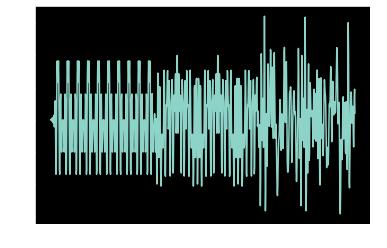

In [15]:
ofdm_out, symbol_stream = ofdm_tx_802_11(2, 'qam16')
plt.plot(ofdm_out.real);

# Receiver

### Packet Detection

In [16]:
# Decimate by 2
rx_input = ofdm_out.copy()
rx_20mhz = rx_input[::2] # Decimated by 2

In [17]:
def rolling_mean(arr, win_size=32):
    '''
    This function is needed because 
    pd.Series(arr).rolling(win_size).mean() 
    does not seem to work properly for complex numbers
    '''
    real_mean = pd.Series(arr.real).rolling(win_size).mean().values
    imag_mean = pd.Series(arr.imag).rolling(win_size).mean().values
    complex_mean = real_mean + 1j*imag_mean
    return complex_mean
    

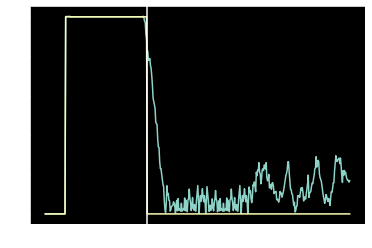

In [18]:
delay = 16
delay_corr = rx_20mhz[:-delay] * rx_20mhz[delay:].conj()
auto_corr = rx_20mhz[:-delay] * rx_20mhz[:-delay].conj()

auto_corr_est = np.abs( rolling_mean(delay_corr) )
var_est = np.abs( rolling_mean(auto_corr) )

comparison_ratio = auto_corr_est/var_est
comparison_ratio = np.nan_to_num(comparison_ratio)

detection_flag = np.zeros_like(comparison_ratio, int)
detection_flag[comparison_ratio > 0.85] = 1

falling_edge = np.where( np.diff(detection_flag)<0 )[0][0]

plt.plot(comparison_ratio);
plt.plot(detection_flag);
plt.axvline(x=falling_edge);

### Frequency Offset Detection